# **Imports**

In [1]:
import pandas as pd
import csv
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchtext.vocab import GloVe
from unidecode import unidecode
import math
import string
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split, Subset
from tqdm import tqdm

# **Mise en forme de la base de données**

In [2]:
def clean(word):
    remove_punct = str.maketrans('', '', string.punctuation)
    if '-' in word:
        words = word.split('-')
    else:
        words = [word]
    for word in words:
        word = word.translate(remove_punct)
        word = unidecode(word)
        word = str.lower(word)
    return words

In [3]:
def clean(word):
    #remove_punct = str.maketrans('', '', string.punctuation)
    #word = word.translate(remove_punct)
    word = unidecode(word)
    word = str.lower(word)
    return word

In [4]:
df = pd.read_csv('transcriptions_with_sex.csv').drop(columns=['subject_line'])

In [5]:
df

,groundtruth,prediction,sex
0,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme
1,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme
2,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme
3,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme
4,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme
...,...,...,...
236,surname: Burlurut firstname: Pétronille occupa...,nom: Burlurut prénom: Gihromille date_naissanc...,femme
237,surname: Combey firstname: Alexandre occupatio...,nom: Comberf prénom: Alexandre date_naissance:...,homme
238,surname: Collin firstname: Marguerite occupati...,nom: Collin prénom: Marguerite date_naissance:...,femme
239,surname: Dumont firstname: Etienne link: fils ...,nom: Dumont prénom: Etienne date_naissance: 19...,homme


In [6]:
def first_treatment(series):
    dic_list = []
    remove_punct = str.maketrans('', '', string.punctuation)
    for row in series:
        individual_dic = {}
        row = row.split(' ')
        row.pop()
        for i in range(len(row)):
            word1 = row[i]
            if len(word1)>0 and word1[-1] == ':':
                word2 = row[i+1]
                word1 = word1[:-1]
                individual_dic[word1] = clean(word2)
        dic_list.append(individual_dic)
    return pd.DataFrame(dic_list)

In [7]:
df_groundtruth = first_treatment(df['groundtruth'])
df_automatic = first_treatment(df['prediction'])

df_groundtruth['sex'] = df['sex']
df_automatic['sex'] = df['sex']

In [8]:
c = 0
for i in df_automatic.index:
    if len(str(df_automatic.iloc[i]['date_naissance']))>2:
        c+=1
c

75

In [9]:
# Calcul des fréquences
freq = df_automatic['sex'].value_counts()

# Calcul des pourcentages
perc = df_automatic['sex'].value_counts(normalize=True) * 100

# Affichage des résultats
print("Fréquences :\n", freq)
print("\nPourcentages :\n", perc)

Fréquences :
 sex
homme     125
femme     107
ambigu      9
Name: count, dtype: int64

Pourcentages :
 sex
homme     51.86722
femme     44.39834
ambigu     3.73444
Name: proportion, dtype: float64


In [10]:
df_automatic.loc[df_automatic['prénom'] == 'jean']

,nom,prénom,date_naissance,lieux_naissance,employeur,relation,profession,état_civil,éducation,sex
14,parrot,jean,33,NaN,NaN,chef,NaN,NaN,NaN,homme
28,schartz,jean,1881,paris,crousier,domestique,cuisiniere,v,NaN,homme
33,ddeg,jean,24,manoeuvre,NaN,f,NaN,NaN,NaN,homme
35,ursat,jean,61,fosgeron,NaN,NaN,NaN,NaN,NaN,homme
58,chapelier,jean,64,maronnier,NaN,NaN,NaN,NaN,NaN,homme
72,paturet,jean,54,NaN,NaN,NaN,NaN,cheus),NaN,homme
91,lecoret,jean,12,p,NaN,a,NaN,NaN,NaN,homme
101,prunier,jean,17,d,NaN,par,NaN,NaN,NaN,homme
102,pichard,jean,53,p,NaN,NaN,NaN,NaN,NaN,homme
105,jean,jean,20,s,NaN,enfant,NaN,NaN,NaN,homme


In [11]:
def from_sex_to_binary(sex):
    if sex == 'femme':
        return 1
    else:
        return 0
    
df_automatic['sex'] = df_automatic['sex'].apply(from_sex_to_binary)

# **Modèle GloVe**

In [12]:
global_vectors = GloVe(name='6B', dim=50)

In [13]:
global_vectors['hervé']

tensor([ 3.2127e-01,  4.0011e-01, -6.9707e-01, -2.5445e-01, -3.1565e-01,
         4.1587e-01,  1.1599e-01,  5.2384e-02, -1.0925e+00,  2.1200e-01,
         8.9384e-01,  2.8341e-01,  1.1022e-01, -5.7718e-01,  3.5705e-01,
        -5.0529e-01,  2.1193e-01,  3.1508e-01, -2.3696e-01, -2.9291e-01,
         6.7544e-02,  3.5066e-01,  1.0638e-02,  9.2169e-04,  3.7801e-01,
         9.7722e-01,  4.0918e-01,  1.6120e-01, -1.2653e-01,  1.1289e+00,
        -1.1393e+00, -4.0986e-01, -5.2876e-01, -1.9988e-02, -3.0398e-01,
        -9.2158e-02, -1.1580e-01,  5.3128e-01, -9.4786e-02,  2.5862e-01,
         1.4105e+00,  1.2179e-01, -9.5736e-04, -1.2194e+00,  3.0270e-01,
        -9.7322e-01, -1.1512e-01, -1.5214e-01,  3.9086e-01,  2.1039e-01])

In [14]:
df_automatic

,nom,prénom,date_naissance,lieux_naissance,employeur,relation,profession,état_civil,éducation,sex
0,chardon,marie,30,"""",NaN,NaN,NaN,NaN,NaN,1
1,lhopital,louis,67,sn,ahef,NaN,NaN,NaN,NaN,0
2,pyrin,marie,55,NaN,NaN,d,NaN,NaN,NaN,1
3,lavocat,marie,1875,rigny,NaN,NaN,'',NaN,NaN,1
4,benne,marguerite,78,id,NaN,'',NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...
236,burlurut,gihromille,61,epouse,NaN,sans,NaN,NaN,NaN,1
237,comberf,alexandre,59,d,NaN,par,fils,NaN,NaN,0
238,collin,marguerite,38,NaN,NaN,NaN,patron,NaN,NaN,1
239,dumont,etienne,1900,id,NaN,NaN,NaN,NaN,NaN,0


In [18]:
l = []
tot = 0
for i in df_automatic.index:
    c = 0
    for token in df_automatic.iloc[i]:
        if not torch.all(global_vectors[token].eq(0)):
            c += 1
    if c < 3:
        tot += 1

print(f'{tot} individus avec moins de 3 covariables ayant un embedding dans le modèle')

28 individus avec moins de 3 covariables ayant un embedding dans le modèle


In [22]:
d = []
for i in df_automatic.index:
    if torch.all(global_vectors[df_automatic['prénom'][i]].eq(0)):
        d.append(df_automatic.loc[i])

print('Le Dataframe des individus dont le prénom n\'apparait pas dans les embeddings')
print(pd.DataFrame(d))

Le Dataframe des individus dont le prénom n'apparait pas dans les embeddings
             nom         prénom date_naissance lieux_naissance employeur  \
18        vivier         angene           180n        aulgique       NaN   
24      debouese       herandre             42            chef       NaN   
25         marhi     oarguerite             30               d       NaN   
34           NaN         vigmie           1852           savit       NaN   
65        fleury       angloise              7              id       NaN   
69         penot          feris           3903             NaN       NaN   
82          brun        jregues              5             NaN       NaN   
94       roumeau          vaude           1804        aulpares       NaN   
104       pegand       gilbeuse             85            chef       NaN   
121    kaermazet      branistau           1908         vipnica    labrye   
126          NaN       mamiolas           1924        commezre       NaN   
132    cuss

In [27]:
tot = 0
for i in df_automatic.index:
    w, z = df_automatic['prénom'][i], df_automatic['nom'][i]
    if torch.all(global_vectors[w].eq(0)) : 
        c = 0
        for token in df_automatic.iloc[i]:
            if not torch.all(global_vectors[token].eq(0)) and not isinstance(token, (float, int)):
                c += 1
        if c == 0:
            tot += 1

print(f'Il y a {tot} individus dont le prénom n\'a pas d\'embedding, et dont aucune des covariables n\'a d\'embedding')

Il y a 1 individus dont le prénom n'a pas d'embedding, et dont aucune des covariables n'a d'embedding


Fonction pour trouver les mots plus proches voisins d'un autre :

In [28]:
def find_nearest_neighbors(word, embeddings, n=5):
    # Ensure the word is in the embeddings vocabulary
    if word not in embeddings.stoi:
        return []

    # Get the vector for the given word
    word_vec = embeddings.vectors[embeddings.stoi[word]].unsqueeze(0)
    
    # Compute cosine similarities between the word and all other vectors
    similarities = F.cosine_similarity(word_vec, embeddings.vectors)
    
    # Find the indices of the top n most similar words
    # Since the word will be most similar to itself, we skip the first result
    nearest_indices = similarities.argsort(descending=True)[1:n+1]
    
    # Map indices back to words
    nearest_neighbors = [embeddings[embeddings.itos[idx]] for idx in nearest_indices]
    
    return nearest_neighbors

Fonction pour définir l'embedding d'un mot comme le barycentre de ses $n$ plus proches voisins :

In [35]:
def strenghen_embedding(word, embeddings, n):
    if n>0:
        stacked_tensors = torch.stack(find_nearest_neighbors(word, embeddings, n) + [embeddings[word]], dim=0)
        mean_tensor = torch.mean(stacked_tensors, dim=0)
        return mean_tensor
    else:
        return embeddings[word]

Covariables d'intérêt :

In [32]:
columns = ['employeur', 'relation', 'profession']

Fonction pour obtenir l'embedding d'une ligne du dataframe :

In [34]:
def single_embeddings(row, model, alpha_surname, nearest_neighbors=0):
    main_embedding = strenghen_embedding(row['prénom'], model, nearest_neighbors)
    residual_embedding = torch.zeros(len(main_embedding))
    for column in columns:
        residual_embedding += strenghen_embedding(row[column], model, nearest_neighbors)
    embedding = alpha_surname * main_embedding + (1-alpha_surname) * residual_embedding
    return embedding

In [36]:
df_automatic['single embedding'] = df_automatic.apply(single_embeddings, axis=1, args=(global_vectors, 0.5, 30)) #Optimal for now 0.3, 30

Transformation des data en Tensors pour les utiliser dans un MLP :

In [37]:
X = torch.stack(list(df_automatic['single embedding']))
Y = torch.tensor(list(df_automatic['sex']))

dataset = TensorDataset(X, Y)

# Calculate sizes for split
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

# Perform the random split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# You can create DataLoader for train and test datasets if needed
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 168
Test dataset size: 73


# **Simple neural network**

In [164]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(50, 64)
        self.dropout1 = nn.Dropout(0.5)  # Dropout layer with a 50% drop rate
        self.fc2 = nn.Linear(64, 128)
        self.dropout2 = nn.Dropout(0.5)  # Another dropout layer
        self.fc3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = torch.sigmoid(self.fc4(x))
        return x


In [39]:
class DynamicNet(nn.Module):
    def __init__(self, num_layers):
        super(DynamicNet, self).__init__()
        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        input_size = 50
        for i in range(num_layers):
            if i < num_layers - 1:  # Intermediate layers
                output_size = 64 if i % 2 == 0 else 128
                self.layers.append(nn.Linear(input_size, output_size))
                self.dropouts.append(nn.Dropout(0.5))
                input_size = output_size
            else:  # Last layer
                self.layers.append(nn.Linear(input_size, 1))
        
    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = F.relu(self.layers[i](x))
            x = self.dropouts[i](x)
        x = torch.sigmoid(self.layers[-1](x))  # Output layer
        return x


## Validations couches, alpha, et nombre de voisins

100%|██████████| 50/50 [00:04<00:00, 10.89it/s]


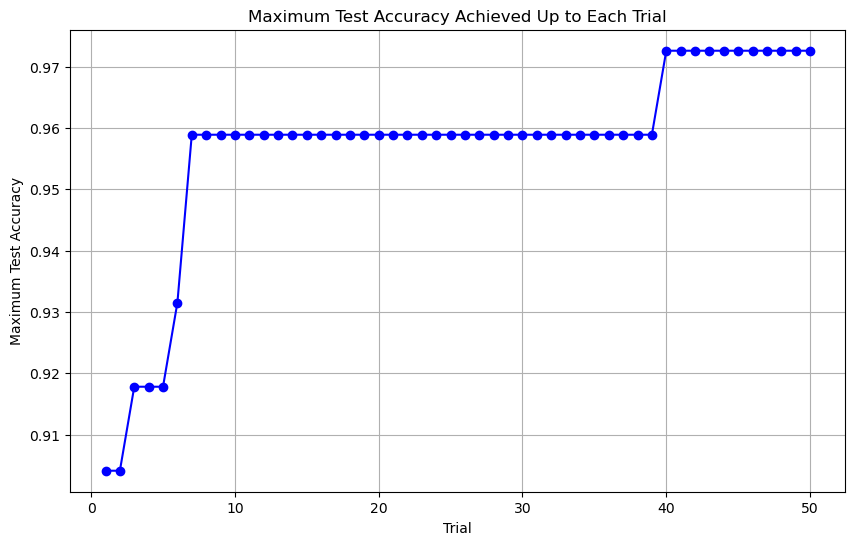

In [173]:
num_trials = 50
num_epochs = 30
final_test_accuracies = []
max_accuracy_up_to_trial = []

for trial in tqdm(range(num_trials)):

    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # You can create DataLoader for train and test datasets if needed
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = Net()
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Test phase for accuracy after training
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            predicted = (outputs.squeeze() >= 0.5).float()
            total_test += labels.size(0)
            correct_test += (predicted == labels).float().sum().item()
    test_accuracy = correct_test / total_test
    final_test_accuracies.append(test_accuracy)

    if trial == 0:
        max_accuracy_up_to_trial.append(test_accuracy)
    else:
        max_accuracy_up_to_trial.append(max(test_accuracy, max_accuracy_up_to_trial[-1]))

# No need to sort final_test_accuracies
# Plotting the maximum accuracy up to each trial
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_trials + 1), max_accuracy_up_to_trial, marker='o', linestyle='-', color='b')
plt.title('Maximum Test Accuracy Achieved Up to Each Trial')
plt.xlabel('Trial')
plt.ylabel('Maximum Test Accuracy')
plt.grid(True)
plt.show()

In [40]:
# Parameters
num_trials = 20
num_epochs = 30
layer_configs = [2, 3, 4, 5, 6, 7]  # Different layer configurations

accuracy_configs = {config: [] for config in layer_configs}
cumulative_avg_accuracy_configs = {config: [] for config in layer_configs}

for config in layer_configs:
    accuracies_per_trial = []
    for trial in tqdm(range(num_trials)):

        train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

        # You can create DataLoader for train and test datasets if needed
        train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        model = DynamicNet(config)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #, weight_decay=1e-5)

        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_dataloader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Test phase for accuracy after training
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = model(inputs)
                predicted = (outputs.squeeze() >= 0.5).float()
                total_test += labels.size(0)
                correct_test += (predicted == labels).float().sum().item()
        test_accuracy = correct_test / total_test
        accuracies_per_trial.append(test_accuracy)
        
        # Calculate cumulative average accuracy up to this trial
        cumulative_avg_accuracy = sum(accuracies_per_trial) / len(accuracies_per_trial)
        cumulative_avg_accuracy_configs[config].append(cumulative_avg_accuracy)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:07<00:00,  6.50it/s]


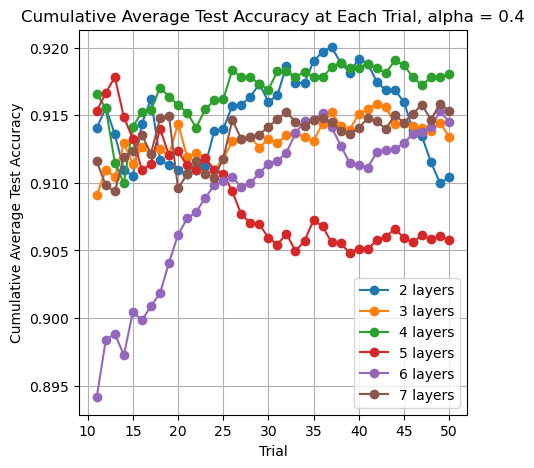

In [41]:
# Plotting
plt.figure(figsize=(5, 5))
for config, avg_accuracies in cumulative_avg_accuracy_configs.items():
    plt.plot(range(1, num_trials + 1)[10:], avg_accuracies[10:], marker='o', linestyle='-', label=f'{config} layers')
plt.title('Cumulative Average Test Accuracy at Each Trial, alpha = 0.4')
plt.xlabel('Trial')
plt.ylabel('Cumulative Average Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
# Parameters
num_trials = 20
num_epochs = 30
alpha_configs = [0, 0.3, 0.5, 0.7, 1]  # Different layer configurations

accuracy_configs = {config: [] for config in alpha_configs}
cumulative_avg_accuracy_configs = {config: [] for config in alpha_configs}

for config in alpha_configs:
    df_automatic['single embedding'] = df_automatic.apply(single_embeddings, axis=1, args=(global_vectors, config, 30))
    accuracies_per_trial = []
    for trial in tqdm(range(num_trials)):

        train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

        # You can create DataLoader for train and test datasets if needed
        train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        model = DynamicNet(3)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_dataloader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Test phase for accuracy after training
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = model(inputs)
                predicted = (outputs.squeeze() >= 0.5).float()
                total_test += labels.size(0)
                correct_test += (predicted == labels).float().sum().item()
        test_accuracy = correct_test / total_test
        accuracies_per_trial.append(test_accuracy)
        
        # Calculate cumulative average accuracy up to this trial
        cumulative_avg_accuracy = sum(accuracies_per_trial) / len(accuracies_per_trial)
        cumulative_avg_accuracy_configs[config].append(cumulative_avg_accuracy)

100%|██████████| 50/50 [00:04<00:00, 11.99it/s]


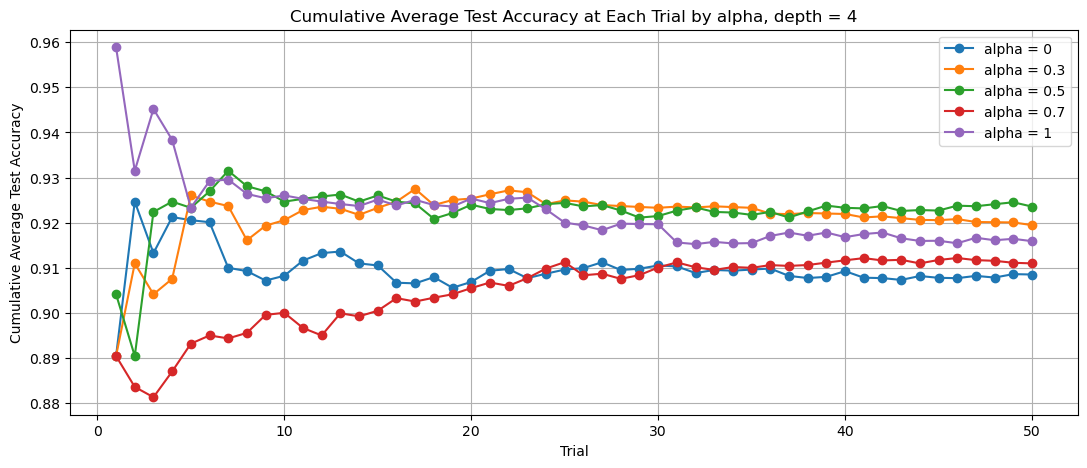

In [43]:
# Plotting
plt.figure(figsize=(13, 5))
for config, avg_accuracies in cumulative_avg_accuracy_configs.items():
    plt.plot(range(1, num_trials + 1), avg_accuracies, marker='o', linestyle='-', label=f'alpha = {config}')
plt.title('Cumulative Average Test Accuracy at Each Trial by alpha, depth = 4')
plt.xlabel('Trial')
plt.ylabel('Cumulative Average Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
# Parameters
num_trials = 20
num_epochs = 30
voisin_configs = [0, 10, 30, 50, 70]  # Different voisins configurations

accuracy_configs = {config: [] for config in voisin_configs}
cumulative_avg_accuracy_configs = {config: [] for config in voisin_configs}

for config in voisin_configs:
    df_automatic['single embedding'] = df_automatic.apply(single_embeddings, axis=1, args=(global_vectors, 0.4, config))
    accuracies_per_trial = []
    for trial in tqdm(range(num_trials)):

        train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

        # You can create DataLoader for train and test datasets if needed
        train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        model = DynamicNet(6)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #, weight_decay=1e-5)

        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_dataloader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Test phase for accuracy after training
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = model(inputs)
                predicted = (outputs.squeeze() >= 0.5).float()
                total_test += labels.size(0)
                correct_test += (predicted == labels).float().sum().item()
        test_accuracy = correct_test / total_test
        accuracies_per_trial.append(test_accuracy)
        
        # Calculate cumulative average accuracy up to this trial
        cumulative_avg_accuracy = sum(accuracies_per_trial) / len(accuracies_per_trial)
        cumulative_avg_accuracy_configs[config].append(cumulative_avg_accuracy)

100%|██████████| 20/20 [00:02<00:00,  7.54it/s]


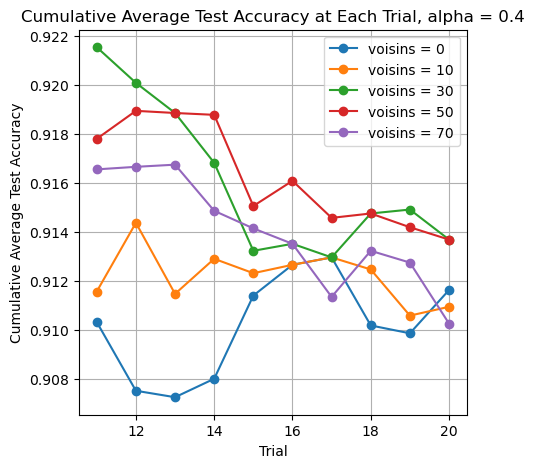

In [45]:
# Plotting
plt.figure(figsize=(5, 5))
for config, avg_accuracies in cumulative_avg_accuracy_configs.items():
    plt.plot(range(1, num_trials + 1)[10:], avg_accuracies[10:], marker='o', linestyle='-', label=f'voisins = {config}')
plt.title('Cumulative Average Test Accuracy at Each Trial, alpha = 0.4')
plt.xlabel('Trial')
plt.ylabel('Cumulative Average Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## KFold

In [49]:
from sklearn.model_selection import KFold

In [51]:
# Hyperparamètres
num_layers_options = [2, 3, 4, 5, 6, 7]
alpha_options = [0.3, 0.4, 0.5, 0.6, 0.7]
num_epochs = 20
k_folds = 3

# Préparation des données
# Assurez-vous que `dataset` est votre dataset PyTorch complet
kf = KFold(n_splits=k_folds, shuffle=True)

results = {}
dataset = TensorDataset(X, Y)

for alpha in alpha_options:
    print(alpha)
    df_automatic['single embedding'] = df_automatic.apply(single_embeddings, axis=1, args=(global_vectors, alpha, 30))
    for num_layers in tqdm(num_layers_options):
        fold_performance = []
        for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset)))):
            # Création des sous-ensembles pour l'entraînement et la validation
            train_subs = Subset(dataset, train_idx)
            val_subs = Subset(dataset, val_idx)
            train_loader = DataLoader(train_subs, batch_size=32, shuffle=True)
            val_loader = DataLoader(val_subs, batch_size=32, shuffle=False)
            
            # Initialisation du modèle, de la fonction de perte et de l'optimiseur
            model = DynamicNet(num_layers)
            criterion = nn.BCELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            
            # Boucle d'entraînement (simplifiée)
            for epoch in range(num_epochs):
                model.train()
                for inputs, labels in train_dataloader:
                    outputs = model(inputs)
                    loss = criterion(outputs.squeeze(), labels.float())
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            
            # Évaluation (simplifiée)
            model.eval()  # Set model to evaluation mode
            correct_test = 0
            total_test = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    predicted = (outputs.squeeze() >= 0.5).float()  # Threshold predictions
                    total_test += labels.size(0)
                    correct_test += (predicted == labels).float().sum().item()
            test_accuracy = correct_test / total_test
            
            fold_performance.append(test_accuracy)
        
        avg_performance = np.mean(fold_performance)
        results[(num_layers, alpha)] = avg_performance

0.3


100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


0.4


100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


0.5


100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


0.6


100%|██████████| 6/6 [00:01<00:00,  4.72it/s]


0.7


100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


In [52]:
# Affichage des résultats
for params, performance in results.items():
    print(f"Layers: {params[0]}, Alphas: {params[1]} -> Avg Accuracy: {performance}")

Layers: 2, Alphas: 0.3 -> Avg Accuracy: 0.9211934156378602
Layers: 3, Alphas: 0.3 -> Avg Accuracy: 0.9378600823045268
Layers: 4, Alphas: 0.3 -> Avg Accuracy: 0.9335390946502059
Layers: 5, Alphas: 0.3 -> Avg Accuracy: 0.9502057613168725
Layers: 6, Alphas: 0.3 -> Avg Accuracy: 0.9460905349794239
Layers: 7, Alphas: 0.3 -> Avg Accuracy: 0.9419238683127572
Layers: 2, Alphas: 0.4 -> Avg Accuracy: 0.9251028806584363
Layers: 3, Alphas: 0.4 -> Avg Accuracy: 0.9294238683127573
Layers: 4, Alphas: 0.4 -> Avg Accuracy: 0.9378600823045268
Layers: 5, Alphas: 0.4 -> Avg Accuracy: 0.9419753086419753
Layers: 6, Alphas: 0.4 -> Avg Accuracy: 0.9502572016460906
Layers: 7, Alphas: 0.4 -> Avg Accuracy: 0.9294753086419753
Layers: 2, Alphas: 0.5 -> Avg Accuracy: 0.9210390946502057
Layers: 3, Alphas: 0.5 -> Avg Accuracy: 0.9419753086419753
Layers: 4, Alphas: 0.5 -> Avg Accuracy: 0.9419238683127572
Layers: 5, Alphas: 0.5 -> Avg Accuracy: 0.933641975308642
Layers: 6, Alphas: 0.5 -> Avg Accuracy: 0.937808641975308

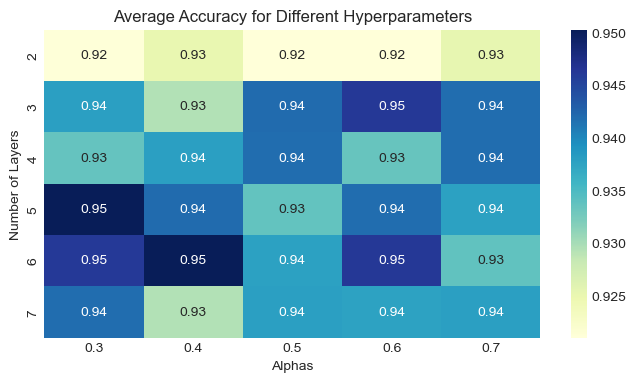

In [53]:
import seaborn as sns

# Conversion des résultats en DataFrame pour faciliter la visualisation
results_df = pd.DataFrame(list(results.items()), columns=['Params', 'AvgAccuracy'])
results_df['NumLayers'] = results_df['Params'].apply(lambda x: x[0])
results_df['Alphas'] = results_df['Params'].apply(lambda x: x[1])
results_df.drop(columns=['Params'], inplace=True)

# Pivotage du DataFrame pour adapter les données au format de heatmap
heatmap_data = results_df.pivot(index='NumLayers', columns='Alphas', values='AvgAccuracy')

# Création du heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Average Accuracy for Different Hyperparameters')
plt.xlabel('Alphas')
plt.ylabel('Number of Layers')
plt.show()

## Analyse avec modèle sélectionné

Nous avons sélectionné un $\alpha = 0.4$, $10$ plus proches voisins, et $6$ couches dans le MLP.

In [54]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# You can create DataLoader for train and test datasets if needed
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [55]:
df_automatic['single embedding'] = df_automatic.apply(single_embeddings, axis=1, args=(global_vectors, 0.4, 10))

In [56]:
# Initialize the model, loss function, and optimizer
#model = BinaryClassificationNet()
model = DynamicNet(6)
criterion = nn.BCELoss()
num_epochs = 100
# Update your optimizer to include L2 regularization (weight decay)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

train_loss_values = []  # To store average training loss per epoch
test_acc_values = []  # To store test accuracy per epoch

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    batch_losses = []
    for inputs, labels in train_dataloader:
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    train_loss = np.mean(batch_losses)
    train_loss_values.append(train_loss)
    
    # Test phase for accuracy
    model.eval()  # Set model to evaluation mode
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            predicted = (outputs.squeeze() >= 0.5).float()  # Threshold predictions
            total_test += labels.size(0)
            correct_test += (predicted == labels).float().sum().item()
    test_accuracy = correct_test / total_test
    test_acc_values.append(test_accuracy)
print(f'Accuracy of the model on the test set: {test_accuracy:.4f}')

Accuracy of the model on the test set: 0.8767


/var/folders/6x/djr3ybxn3_d3j76smv6vqyfh0000gn/T/ipykernel_46183/772294488.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')  # 'ggplot' or 'seaborn' are also good choices for professional visuals


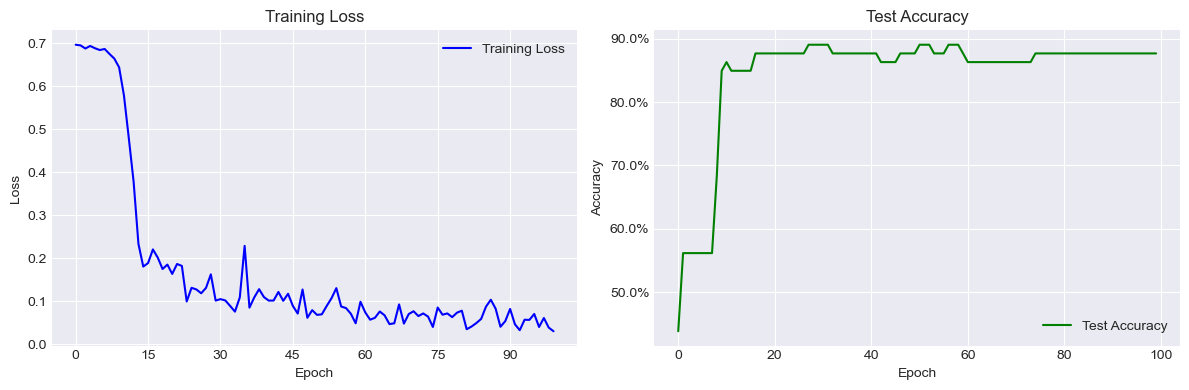

In [58]:
import matplotlib.ticker as ticker

# Set a visually appealing style for scientific reports
plt.style.use('seaborn-darkgrid')  # 'ggplot' or 'seaborn' are also good choices for professional visuals

# Create a figure with a specified size and higher resolution
plt.figure(figsize=(12, 4), dpi=100)

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Training Loss', color='blue', linestyle='-', linewidth=1.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)  # Adds a grid for better readability
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plotting test accuracy
plt.subplot(1, 2, 2)
plt.plot(test_acc_values, label='Test Accuracy', color='green', linestyle='-', linewidth=1.5)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1.0))  # Format as percentage, assuming accuracy is between 0 and 1

# Adjust layout to avoid overlap and ensure clarity
plt.tight_layout()

# Optionally save the figure in high-resolution for reports or presentations
plt.savefig('training_evaluation.png', format='png', dpi=300)

# Display the plot
plt.show()

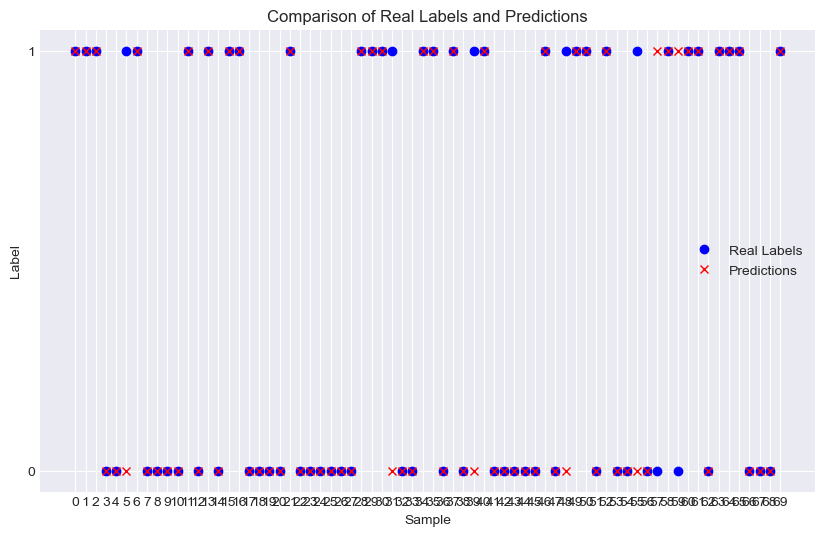

In [59]:
# Choose a subset size for visualization
subset_size = 70

model.eval()  # Ensure the model is in evaluation mode
predictions = []
real_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        predicted = (outputs.squeeze() >= 0.5).float()  # Convert probabilities to binary predictions
        predictions.extend(predicted.tolist())
        real_labels.extend(labels.tolist())

# Select a subset of the real labels and predictions for visualization
predictions_subset = predictions[:subset_size]
real_labels_subset = real_labels[:subset_size]

indices = range(len(real_labels_subset))

plt.figure(figsize=(10, 6))
plt.plot(indices, real_labels_subset, 'bo', label='Real Labels')
plt.plot(indices, predictions_subset, 'rx', label='Predictions')
plt.xlabel('Sample')
plt.ylabel('Label')
plt.title('Comparison of Real Labels and Predictions')
plt.xticks(indices)
plt.yticks([0, 1])
plt.legend()
plt.grid(True)
plt.show()

In [60]:
def get_predictions(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    with torch.no_grad():  # No need to track gradients
        for inputs, _ in data_loader:  # Assuming labels are not needed for prediction
            inputs = inputs.unsqueeze(1)  # Add channel dimension and move to device
            outputs = model(inputs)
            predicted = (outputs.squeeze() >= 0.5).float()  # Convert to binary predictions
            predictions.extend(predicted.cpu().tolist())  # Move predictions to CPU and convert to list
    return predictions

# Generate predictions
full_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

preds = get_predictions(model, full_dataloader)

df_automatic['preds'] = preds

df_automatic.loc[df_automatic['preds'] != df_automatic['sex']]

,nom,prénom,date_naissance,lieux_naissance,employeur,relation,profession,état_civil,éducation,sex,single embedding,preds
59,gorbinet,jeanne,66,id,NaN,id,NaN,NaN,NaN,0,"[tensor(0.0532), tensor(0.2300), tensor(0.5256...",1.0
65,fleury,angloise,7,id,NaN,NaN,NaN,',NaN,0,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....",1.0
82,brun,jregues,5,NaN,NaN,NaN,NaN,chef,NaN,0,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....",1.0
123,chardon,marie,84,"""",NaN,d,NaN,NaN,NaN,0,"[tensor(0.1361), tensor(0.7602), tensor(0.1158...",1.0
130,martin,marie,47,p,NaN,NaN,id,id,NaN,0,"[tensor(0.0665), tensor(0.4672), tensor(0.2740...",1.0
135,gaulne,francoise,41,NaN,1opne,chacon,polisseur,m,NaN,1,"[tensor(0.0678), tensor(-0.1468), tensor(-0.26...",0.0
146,pesin,marie,1891,coulonges,NaN,culliniere,lameau,NaN,NaN,0,"[tensor(0.1798), tensor(0.4375), tensor(-0.282...",1.0
149,dasquier,augustine,plan,NaN,NaN,NaN,NaN,vitant,NaN,1,"[tensor(0.1752), tensor(0.1423), tensor(-0.407...",0.0
154,derroyies,leonie,55,aentin,NaN,chef,NaN,NaN,NaN,1,"[tensor(-0.0195), tensor(-0.0818), tensor(-0.6...",0.0
166,NaN,clemence,1917,"""",NaN,fille,NaN,NaN,NaN,1,"[tensor(-0.1088), tensor(-0.0043), tensor(-0.6...",0.0
